<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/william-dove/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Deep Learning with CNNs for Star Morphology Analysis

In this final assignment, you will use the same FITS files you explored previously, which contain astronomical images of stars in a specific region of the sky. This time, you will train a convolutional neural network (CNN) to classify stars based on morphological features directly from cropped image patches extracted from the FITS image.

The CNN will be used to:
- Distinguish between point sources (stars), extended sources (galaxies or nebula fragments), and image artifacts (like hot pixels or diffraction spikes).
- Optionally predict star brightness class (dim, moderate, bright) or other physically relevant labels.

### Learning Objectives:

By the end of this assignment, you should be able to:
- Understand how convolutional neural networks extract spatial features from astronomical images.
- Build and train a CNN using TensorFlow.
- Evaluate and visualize model performance on scientific image data.

In [2]:
# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 27.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm
from astroquery.simbad import Simbad
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO
import pandas as pd

## Task 1: Data Preparation (8 points)
- Use the same FITS file from Homework 5
- Use astropy to determine the wcs coordinates of the image
- Generate a pandas list os the 10 brightest objects in the image

In [4]:
# Fetch the .fits file
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/12up.fits"
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors
hdul = fits.open(BytesIO(response.content)) # Load the FITS file into an HDUList using BytesIO
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close()

# Get the WCS data
wcs = WCS(hdul[0].header, naxis=2)
print(f'World Coordinate System image info: \n{wcs}')

World Coordinate System image info: 
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 38.1907275430269 61.1734434293662 
CRPIX : 1079.5 955.5 
PC1_1 PC1_2  : 0.0425360473258291 -0.999094932765598 
PC2_1 PC2_2  : 0.999101803383238 0.042374361073203 
CDELT : -0.0011097585372881 0.00110916799996926 
NAXIS : 2159  1911  3


In [5]:
# Function for use in detecting bright parts of the image
def detect_stars(channel_data):
    """
    Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=15.0*std)
    return finder(channel_data - median)

In [23]:
# Create an astropy table of the objects found in the image using the above function
avg_channel = np.mean(rgb_data, axis=2)
sources = detect_stars(avg_channel)

# Sort the table by object brightness, convert to pd dataframe.
sources.sort('flux', reverse=True) # We sort by 'flux' instead of 'peak' because we want the total brightness, not just the max of each object
sources_df = sources[:10].to_pandas()

# Add in WCS info
sky_coords = wcs.pixel_to_world(sources_df['xcentroid'].values, sources_df['ycentroid'].values)
sources_df['ra'] = sky_coords.ra.degree
sources_df['dec'] = sky_coords.dec.degree

# Display
print(f'Top 10 objects by brightness: \n')
sources_df

Top 10 objects by brightness: 



,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec
0,122,1460.522784,209.716902,0.473069,0.192104,0.163197,25,57278.000000,562842.000000,-14.375966,-6.775423,36.419398,61.550310
1,732,18.829658,962.176483,0.522951,0.022978,0.313018,25,51946.333333,425269.333333,-14.071660,-6.737427,38.307767,59.999620
2,737,1584.563814,965.946602,0.494125,-0.133686,0.113942,25,43547.000000,379779.000000,-13.948827,-6.552693,38.167084,61.734767
3,1225,83.817762,1438.310491,0.592815,-0.038626,0.332938,25,42969.666667,364984.333333,-13.905686,-6.405419,39.360446,60.088871
4,56,73.202614,87.273810,0.468806,0.589389,0.133611,25,33456.333333,353484.666667,-13.870926,-6.141916,36.362508,60.006169
5,347,2044.433521,532.877768,0.540982,0.006581,0.059104,25,32316.000000,275164.000000,-13.598979,-6.166339,37.090076,62.219570
6,69,533.407149,119.322883,0.497232,0.345818,0.111277,25,25077.000000,251159.000000,-13.499872,-5.831063,36.361508,60.517650
7,1618,1153.438441,1823.377439,0.515300,-0.331386,0.085351,25,25192.666667,244641.333333,-13.471325,-5.835437,40.188466,61.282649
8,1579,1335.667596,1802.158988,0.504870,-0.124872,0.144257,25,25775.666667,240205.666667,-13.451458,-5.907782,40.134071,61.484441
9,536,671.226947,749.042836,0.601717,0.141329,0.228390,25,33973.333333,237141.000000,-13.437517,-6.263919,37.764381,60.711792


Below is an image with the WCS coordinates displayed and the top 10 bright objects circled

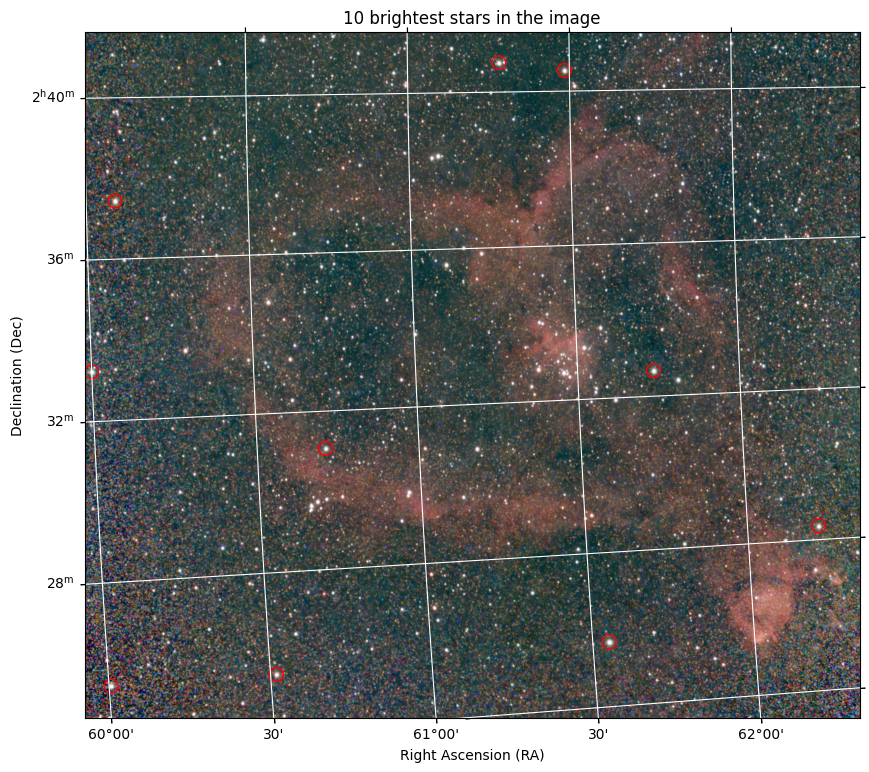

In [15]:
# Plot detected stars (average channel)
plt.figure(figsize=(10, 10))

ax = plt.subplot(projection=wcs) # Project the sky coordinates of the image stored in wcs
plt.imshow(apply_stretch(rgb_data), origin='lower')
ax.coords.grid(color='white', ls='solid')
plt.scatter(sources_df['xcentroid'], sources_df['ycentroid'], s=100, edgecolor='red', facecolors='none')

plt.title('10 brightest stars in the image')
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.show()

## Task 2: Determine the properties of the stars based on a catalog (8 points)
- use the SIMBAD catalog (available through astropy) to determine the following properties of the 10 brightest objects in you image:
    - Name of the object
    - Spectral class
    - object type
    - absolute magnitude (you might have to calculate it)
    - distance to earth

In [33]:
coords = SkyCoord(ra=sources_df['ra'][0]*u.deg, dec=sources_df['dec'][0]*u.deg, unit='deg', frame='icrs')
coords

# 36.419398	61.550310 # 38.307767	59.999620

Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields('mesdistance', 'V', 'sp', 'otype', 'ids')

# result = Simbad.query_region(coords, radius=1/360) # Radius in arcseconds
result = Simbad.query_region(SkyCoord(38.307767, 59.999620, unit=(u.deg, u.deg), frame='icrs'), radius=2 * u.arcsec)
result

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,V,otype,ids,mesdistance.bibcode,mesdistance.dist,mesdistance.dist_prec,mesdistance.mespos,mesdistance.method,mesdistance.minus_err,mesdistance.minus_err_prec,mesdistance.plus_err,mesdistance.plus_err_prec,mesdistance.qual,mesdistance.unit,sp_type,sp_qual,sp_bibcode
,deg,deg,mas,mas,deg,,,,,,,,,,,,,,,,,,,
object,float64,float64,float32,float32,int16,str1,object,float64,object,object,object,float64,int16,int16,object,float64,int16,float64,int16,str1,object,object,str1,object


In [35]:
'''
result_table = Simbad.query_object(sources_df['id'])
print(result_table)
'''

Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields('mesdistance', 'V', 'sp', 'otype', 'ids')

for idx, row in tqdm(sources_df.iterrows(), total=sources_df.shape[0]):
  ra, dec = row['ra'], row['dec']
  # coords = SkyCoord(ra=row['ra']*u.deg, dec=row['dec']*u.deg, unit='deg', frame='icrs')
  # coords = SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
  coords = SkyCoord(row['ra'], row['dec'], unit=(u.deg, u.deg), frame='icrs')
  # print(coords)
  try:
    result = Simbad.query_region(coords, radius=1*u.arcsec) # Radius in arcseconds
    if result:
      sources_df.at[idx, 'star_name'] = result[0]['main_id']
      sources_df.at[idx, 'spectral_type'] = result[0]['sp_type']
      sources_df.at[idx, 'object_type'] = result[0]['otype']
      sources_df.at[idx, 'visual_mag'] = result[0]['V']

      dist = result[0]['mesdistance.dist']
      sources_df.at[idx, 'simbad_distance_pc'] = float(dist) if dist is not None else None
  except Exception as e:
    print(f'Error for {idx}: {e}')


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


## Task 3: Visualize and label (10 points)
Draw a 64x64 patch of each of the 10 brightest objects and generate a list to label each patch based on:

- Morphology
    - star
    - extended (nebula, galaxy, cluster, ...)
    - artifact (hot pixel, cosmic ray, ...)
    - if you do not have all types, artificially generate one example of each. Use a LLM to have specific shapes suggested. Document if it suggests useful shapes.
- Brightness class
- Spectral class

## Task 4: Build a CNN (8 points)
- Use TensorFlow/Keras to build a small CNN.
    - Recommended architecture:
    - Conv2D → ReLU → MaxPool
    - Conv2D → ReLU → MaxPool
    - Flatten → Dense → Softmax

You can adapt this depending on whether you are doing binary or multi-class classification.

## Task 5: Train the Model (10 points)

Now use the top 100 (you can also use more to generate better training data) objects with all information in your image to train your model on the parameters spectral class and absolute magnitude and distance if possible. If you do not have all types genererate 10 examples of each type missing.
Store the resulting pandas dataframe as `catalog.csv` in the same directory as you Jupyter notebook.

Split your dataset into training, validation, and test sets.
- Use categorical crossentropy loss and an appropriate optimizer (e.g., Adam).
- Plot training and validation accuracy/loss curves.

Hint: SIMBAD has a very detailed set of spectral types. Group them according to the main letter (O, B, A, F, G, K, M)

Ask a LLM what final plot you should generate that shows if the CNN works for classification. Generate that plot.